# Support Vector Classifier (SVC)
## Josiah's Traditional ML Comparison Model

In [61]:
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# for SVC Model
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

## Extract Premier League Soccer Data

In [42]:
premier_results = pd.read_csv("premier_data/premier_matches.csv")

C:\Users\mathewsj\AppData\Local\Temp\ipykernel_37776\1946633246.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  premier_results = pd.read_csv("premier_data/premier_matches.csv")


#### Clean/Encode Data!

In [43]:
# POSSIBLY drop betting odds and other cols
some_cols_to_drop = [
    "MaxOver25", "MaxUnder25",
    "HandiSize", "HandiHome", "HandiAway",
    # "C_LTH", "C_LTA", "C_VHD", "C_VAD", "C_PHB", "C_HTB",   [Maybe?]
    # "OddHome", "OddDraw", "OddAway",  [CAN USE!]
    "MaxHome", "MaxDraw", "MaxAway", "Over25", "Under25",
    "MatchTime"  # Odd TIME cols
]
premier_results = premier_results.drop(columns=some_cols_to_drop)

In [44]:
# Grab PREMIER LEAGUE data
premier_results = premier_results[premier_results['Division'] == 'E0'].copy()
premier_results.head(20)

# Extract only Year from datetime conversion object
premier_results['MatchDate'] = pd.to_datetime(premier_results['MatchDate']).dt.year

# Pull recent DATA (-20 years)
premier_results = premier_results[premier_results['MatchDate'] >= 2005]
premier_results = premier_results[premier_results['MatchDate'] <= 2024]

# Grab ONLY Premier League Data - Division Code = E0
premier_results = premier_results[premier_results['Division'] == 'E0']
pd.set_option('display.max_columns', None)

# Drop DRAWs for BINARY CLASSIFICATION
premier_results = premier_results[premier_results['FTResult'] != 'D'].copy()
premier_results.head(15)

,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,FTHome,FTAway,FTResult,HTHome,HTAway,HTResult,HomeShots,AwayShots,HomeTarget,AwayTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,OddHome,OddDraw,OddAway,C_LTH,C_LTA,C_VHD,C_VAD,C_HTB,C_PHB
24809,E0,2005,Aston Villa,Blackburn,1709.45,1663.23,0.0,1.0,5.0,6.0,1.0,0.0,H,0.0,0.0,D,11.0,9.0,3.0,4.0,9.0,9.0,6.0,7.0,1.0,0.0,0.0,0.0,1.90,3.10,4.33,0.0190,0.8850,0.0261,0.0100,0.0118,0.0482
24811,E0,2005,Charlton,Arsenal,1703.99,1913.54,7.0,13.0,9.0,13.0,1.0,3.0,A,1.0,1.0,D,7.0,8.0,4.0,5.0,13.0,15.0,1.0,2.0,1.0,1.0,0.0,0.0,6.00,3.40,1.61,0.0215,0.6711,0.2269,0.0099,0.0373,0.0332
24812,E0,2005,Fulham,Crystal Palace,1658.58,1570.47,0.0,4.0,1.0,2.0,3.0,1.0,H,1.0,1.0,D,12.0,7.0,6.0,3.0,11.0,18.0,4.0,2.0,1.0,3.0,0.0,0.0,2.00,3.20,3.75,0.0315,0.1651,0.4784,0.0100,0.2839,0.0312
24813,E0,2005,Liverpool,Chelsea,1807.79,1919.25,9.0,10.0,9.0,13.0,0.0,1.0,A,0.0,0.0,D,14.0,8.0,7.0,7.0,14.0,16.0,3.0,2.0,2.0,2.0,0.0,0.0,3.10,3.20,2.25,0.2284,0.2172,0.0264,0.2805,0.1952,0.0522
24814,E0,2005,Man City,Southampton,1684.93,1627.79,4.0,4.0,1.0,2.0,2.0,1.0,H,2.0,0.0,H,15.0,6.0,8.0,1.0,12.0,9.0,9.0,8.0,0.0,0.0,0.0,0.0,1.72,3.40,5.00,0.8094,0.0866,0.0181,0.0380,0.0119,0.0361
24815,E0,2005,Middlesbrough,Man United,1749.94,1875.94,6.0,10.0,9.0,13.0,0.0,2.0,A,0.0,1.0,A,6.0,13.0,2.0,7.0,13.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,3.50,3.20,2.10,0.1980,0.0285,0.3938,0.0159,0.3534,0.0105
24816,E0,2005,Newcastle,Birmingham,1741.52,1697.41,1.0,2.0,9.0,12.0,2.0,1.0,H,2.0,0.0,H,8.0,10.0,4.0,8.0,8.0,14.0,6.0,5.0,1.0,2.0,0.0,0.0,1.90,3.10,4.33,0.1213,0.0430,0.6630,0.0099,0.0938,0.0690
24818,E0,2005,Tottenham,Everton,1693.87,1719.40,7.0,13.0,4.0,10.0,5.0,2.0,H,2.0,1.0,H,14.0,6.0,12.0,3.0,8.0,13.0,6.0,4.0,0.0,0.0,0.0,0.0,2.25,3.20,3.10,0.0284,0.0613,0.8364,0.0099,0.0540,0.0099
24866,E0,2005,Blackburn,Charlton,1663.23,1703.99,4.0,6.0,4.0,10.0,1.0,0.0,H,1.0,0.0,H,16.0,9.0,11.0,6.0,11.0,14.0,6.0,8.0,2.0,3.0,0.0,0.0,2.30,3.20,2.70,0.1636,0.0167,0.0204,0.1312,0.6313,0.0368
24867,E0,2005,Crystal Palace,Aston Villa,1570.47,1709.45,1.0,2.0,3.0,3.0,2.0,0.0,H,1.0,0.0,H,14.0,12.0,9.0,6.0,8.0,14.0,7.0,7.0,2.0,3.0,0.0,0.0,2.50,3.20,2.50,0.2072,0.2774,0.0230,0.1080,0.2626,0.1217


In [45]:
print(f"W/L ROWS: {premier_results.shape[0]}")
premier_results.head()
# Map H/A to 0/1
# H (Home Win) = 0
# A (Away Win) = 1

premier_results['FTResult'] = premier_results['FTResult'].map({'H': 1, 'A': 0})  # AWAY WINS weighted HIGHER?

premier_results.head(20)

W/L ROWS: 5711


,Division,MatchDate,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,Form5Away,FTHome,FTAway,FTResult,HTHome,HTAway,HTResult,HomeShots,AwayShots,HomeTarget,AwayTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,OddHome,OddDraw,OddAway,C_LTH,C_LTA,C_VHD,C_VAD,C_HTB,C_PHB
24809,E0,2005,Aston Villa,Blackburn,1709.45,1663.23,0.0,1.0,5.0,6.0,1.0,0.0,1,0.0,0.0,D,11.0,9.0,3.0,4.0,9.0,9.0,6.0,7.0,1.0,0.0,0.0,0.0,1.90,3.10,4.33,0.0190,0.8850,0.0261,0.0100,0.0118,0.0482
24811,E0,2005,Charlton,Arsenal,1703.99,1913.54,7.0,13.0,9.0,13.0,1.0,3.0,0,1.0,1.0,D,7.0,8.0,4.0,5.0,13.0,15.0,1.0,2.0,1.0,1.0,0.0,0.0,6.00,3.40,1.61,0.0215,0.6711,0.2269,0.0099,0.0373,0.0332
24812,E0,2005,Fulham,Crystal Palace,1658.58,1570.47,0.0,4.0,1.0,2.0,3.0,1.0,1,1.0,1.0,D,12.0,7.0,6.0,3.0,11.0,18.0,4.0,2.0,1.0,3.0,0.0,0.0,2.00,3.20,3.75,0.0315,0.1651,0.4784,0.0100,0.2839,0.0312
24813,E0,2005,Liverpool,Chelsea,1807.79,1919.25,9.0,10.0,9.0,13.0,0.0,1.0,0,0.0,0.0,D,14.0,8.0,7.0,7.0,14.0,16.0,3.0,2.0,2.0,2.0,0.0,0.0,3.10,3.20,2.25,0.2284,0.2172,0.0264,0.2805,0.1952,0.0522
24814,E0,2005,Man City,Southampton,1684.93,1627.79,4.0,4.0,1.0,2.0,2.0,1.0,1,2.0,0.0,H,15.0,6.0,8.0,1.0,12.0,9.0,9.0,8.0,0.0,0.0,0.0,0.0,1.72,3.40,5.00,0.8094,0.0866,0.0181,0.0380,0.0119,0.0361
24815,E0,2005,Middlesbrough,Man United,1749.94,1875.94,6.0,10.0,9.0,13.0,0.0,2.0,0,0.0,1.0,A,6.0,13.0,2.0,7.0,13.0,9.0,10.0,4.0,1.0,0.0,0.0,0.0,3.50,3.20,2.10,0.1980,0.0285,0.3938,0.0159,0.3534,0.0105
24816,E0,2005,Newcastle,Birmingham,1741.52,1697.41,1.0,2.0,9.0,12.0,2.0,1.0,1,2.0,0.0,H,8.0,10.0,4.0,8.0,8.0,14.0,6.0,5.0,1.0,2.0,0.0,0.0,1.90,3.10,4.33,0.1213,0.0430,0.6630,0.0099,0.0938,0.0690
24818,E0,2005,Tottenham,Everton,1693.87,1719.40,7.0,13.0,4.0,10.0,5.0,2.0,1,2.0,1.0,H,14.0,6.0,12.0,3.0,8.0,13.0,6.0,4.0,0.0,0.0,0.0,0.0,2.25,3.20,3.10,0.0284,0.0613,0.8364,0.0099,0.0540,0.0099
24866,E0,2005,Blackburn,Charlton,1663.23,1703.99,4.0,6.0,4.0,10.0,1.0,0.0,1,1.0,0.0,H,16.0,9.0,11.0,6.0,11.0,14.0,6.0,8.0,2.0,3.0,0.0,0.0,2.30,3.20,2.70,0.1636,0.0167,0.0204,0.1312,0.6313,0.0368
24867,E0,2005,Crystal Palace,Aston Villa,1570.47,1709.45,1.0,2.0,3.0,3.0,2.0,0.0,1,1.0,0.0,H,14.0,12.0,9.0,6.0,8.0,14.0,7.0,7.0,2.0,3.0,0.0,0.0,2.50,3.20,2.50,0.2072,0.2774,0.0230,0.1080,0.2626,0.1217


In [46]:
# Drop any row that is missing Odds or Elo
cols_to_check = ['HomeElo', 'AwayElo', 'OddHome', 'OddAway']
premier_results = premier_results.dropna(subset=cols_to_check)

In [47]:
# Train/Test Split
train, test = train_test_split(premier_results, test_size=0.2, random_state=0)
print(f"Rows: {premier_results.shape[0]}")

Rows: 5709


In [48]:
X_train = train[['HomeElo',	'AwayElo', 'OddHome', 'OddAway', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away']]  # before the game 'starts'
y_train = train['FTResult']  # 'after' game

X_test = test[['HomeElo',	'AwayElo', 'OddHome', 'OddAway', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away']]   # before the game 'starts'
y_test =  test['FTResult']

In [49]:
# Using Standard Scaler to fit/transform and SCALE data!
data_scaler = StandardScaler()

X_train_scaled = data_scaler.fit_transform(X_train)
X_test_scaled = data_scaler.fit_transform(X_test)

## Create the (non-linear) SVC Model!

In [50]:
#NON-Scale test
svc_model = SVC(kernel='rbf', C=1.0)  #non-linear 'bubble' = rbf model
svc_model.fit(X_train, y_train) # uses Labels for Regulation and updating?

predicted = svc_model.predict(X_test)
metrics.accuracy_score(predicted,y_test)

0.702276707530648

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Define the "Grid" of values to test
# C: How much you punish errors (Low = Soft margin, High = Hard margin)
# gamma: How far the influence of a single training example reaches
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# 2. Run the Search (This trains 80 different models!)
# verbose=2 lets you see the progress
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train_scaled, y_train)

# 3. Print the Winner
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Accuracy: {grid.best_score_:.4f}")

# 4. Use the best model to predict
grid_predictions = grid.predict(X_test_scaled)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01

In [52]:
svc_model = SVC(kernel='rbf', C=50.0, gamma=0.1)  #non-linear 'bubble' = rbf model
svc_model.fit(X_train_scaled, y_train) # uses Labels for Regulation and updating?

predicted = svc_model.predict(X_test_scaled)
metrics.accuracy_score(predicted,y_test)

0.7119089316987741

In [55]:
DecisionBoundaryDisplay.from_estimator(
        svc_model,
        X_train_scaled,
        response_method="predict",
        alpha=0.8,
        cmap="Pastel1",
        xlabel='Soccer Cols',
        ylabel='Win?',
    )

plt.scatter(X[:, 0], X[:, 1],
            c=y,
            s=20, edgecolors="k")
plt.show()

ValueError: n_features must be equal to 2. Got 8 instead.

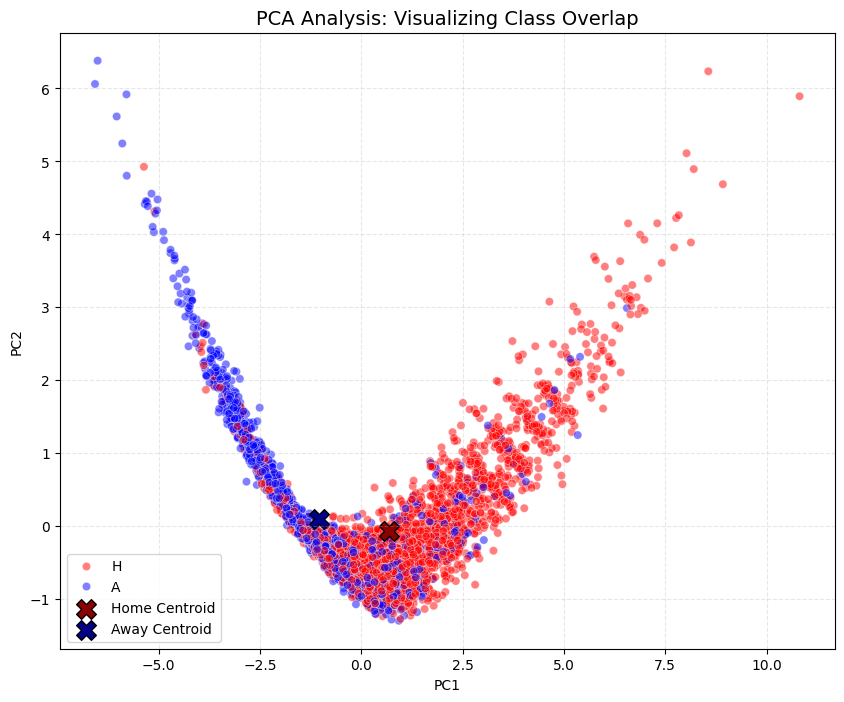

In [63]:
# 1. Feature Engineering (The "Diff" variables that reveal the noise)
# Use your main dataframe variable (e.g., df or matches)
df_pca = premier_results.copy()
df_pca = df_pca[df_pca['FTResult'] != 'D'] # Remove draws

# Create the engineered features
df_pca['Elo_Diff'] = df_pca['HomeElo'] - df_pca['AwayElo']
df_pca['Form_Diff'] = df_pca['Form5Home'] - df_pca['Form5Away']
df_pca['Odds_Ratio'] = df_pca['OddAway'] / df_pca['OddHome']

# Select features and clean
features = ['Elo_Diff', 'Form_Diff', 'Odds_Ratio', 'OddHome', 'OddAway']
df_pca = df_pca.dropna(subset=features)

X_pca_data = df_pca[features]
y_pca_data = df_pca['FTResult']

# 2. Scale & Transform (StandardScaler is required for PCA)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(X_pca_data)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_pca)

# 3. Create Plotting DataFrame
# 1. Create Plotting DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# --- THE FIX: Use .values to ignore index mismatch ---
# This ensures the rows align by position, not by the old index numbers
raw_results = y_pca_data.values if hasattr(y_pca_data, 'values') else y_pca_data
pca_df['Result'] = raw_results

# 2. Robust Mapping (Handles 0/1 integers OR 'H'/'A' strings)
# We convert to string first so the map works for both types
pca_df['Result'] = pca_df['Result'].astype(str).map({
    '1': 'H', '1.0': 'H', 'H': 'H',
    '0': 'A', '0.0': 'A', 'A': 'A'
})

# Drop any rows where mapping failed (just in case)
pca_df = pca_df.dropna(subset=['Result'])

# 3. Generate the "Purple Fog" Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Result',
    data=pca_df,
    palette={'H': 'red', 'A': 'blue'},
    alpha=0.5
)

# Add Centroids for clarity
centroids = pca_df.groupby('Result')[['PC1', 'PC2']].mean()

# Check if keys exist before plotting to prevent KeyError
if 'H' in centroids.index:
    plt.scatter(centroids.loc['H', 'PC1'], centroids.loc['H', 'PC2'],
                c='darkred', s=200, marker='X', edgecolors='black', label='Home Centroid')
if 'A' in centroids.index:
    plt.scatter(centroids.loc['A', 'PC1'], centroids.loc['A', 'PC2'],
                c='darkblue', s=200, marker='X', edgecolors='black', label='Away Centroid')

plt.title('PCA Analysis: Visualizing Class Overlap', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()